# Simple SWAG example for Logistic Regression

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from swag.train import *
from swag.models import SimpleLR
%matplotlib inline
torch.manual_seed(0)
np.random.seed(0)

- task: you have only one option here
- batch_size: batch size
- n_epoch: number of epoches for logistic regression pretraining
- lr: learning rate for logistic regression pretraining
- rank: rank of non-diagonal SWAG covariance approximation,
- C: use every C weights for moving-mean statistics update,
- n_steps_swag: number of steps for SWAG,
- lr_swag: learning rate for SGD in SWAG

In [2]:
params = {"task": "australian",
          "batch_size": 32,
          "n_epoch": 150,
          "lr": 0.0005,
          "rank": 10,
          "C": 20,
          "n_steps_swag": 80,
          "lr_swag": 1e-6
         }

Loading data:

In [3]:
X_train = pd.read_csv('data/australian_presplit/australian_scale_X_tr.csv', delim_whitespace=True)
y_train = pd.read_csv('data/australian_presplit/australian_scale_y_tr.csv', delim_whitespace=True)
X = torch.tensor(X_train.values, dtype = torch.float)
X = torch.cat([X, torch.ones(X.shape[0], 1, dtype = torch.float)], dim = -1)
y = torch.tensor(y_train.values, dtype = torch.float32).view(-1)

X_test = pd.read_csv('data/australian_presplit/australian_scale_X_te.csv', delim_whitespace=True)
y_test = pd.read_csv('data/australian_presplit/australian_scale_y_te.csv', delim_whitespace=True)
X_test = torch.tensor(X_test.values, dtype = torch.float)
X_test = torch.cat([X_test, torch.ones(X_test.shape[0], 1, dtype = torch.float)], dim = -1)
y_test = torch.tensor(y_test.values, dtype = torch.float32).view(-1)

Pretraining and evaluating non-bayesian Logistic Regression

In [4]:
model = SimpleLR(X.shape[1], max_rank = params["rank"])

loss = train_simple_lr(model, X, y, params)

nll = nn.BCEWithLogitsLoss()(model(X_test, sample = False), y_test)
nll

tensor(0.4224, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

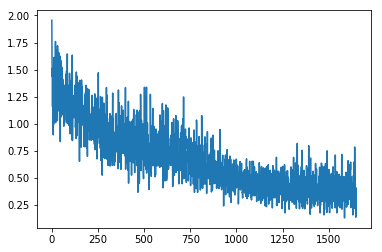

In [5]:
plt.plot(loss)

Run SWAG (approximate $\mu, U, d$)

In [6]:
mu, U, d, loss = run_swag_lr(model, X, y, params)

Obtained covariance matrix:

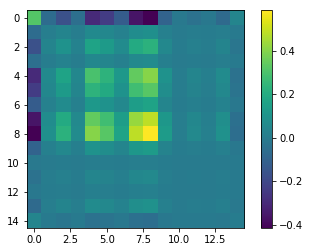

In [7]:
plt.imshow((U @ U.t() + torch.diag(d)).detach())
plt.colorbar()

Check if model didn't diverged:

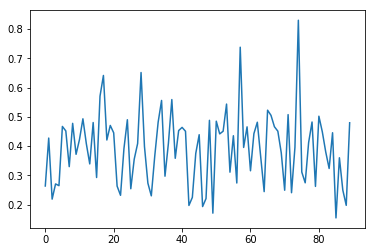

In [8]:
plt.plot(loss)

Evaluate NLL for bayesian Logistic Regression:

In [9]:
model.mu = nn.Parameter(mu)
model.U = nn.Parameter(U)
model.d = nn.Parameter(d)

model.nll_loss(X_test, y_test, n_samples = 500)

tensor(0.4033, grad_fn=<NegBackward>)